## Dependencies

In [1]:
import random

import torch

import context_changers
import ct_model
import dmc
import drqv2
import utils
import numpy as np

import imageio
from matplotlib import pyplot as plt

## Hyperparameters

In [2]:
task_name = 'reacher_hard' # Name of the task
expert_frame_stack = 3  # Size of the frame stack with which the expert was trained
action_repeat = 2  # Number of action repeat
seed = 1242
xml_path = 'domain_xmls/reacher.xml'  # XML of the task with some updates
episode_len = 1000  # Length of the episode
context_camera_ids = [0]  # Number of camera
learner_camera_id = 0
im_w = 64
im_h = 64

cam_id = random.choice(context_camera_ids)

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
utils.set_seed_everywhere(seed)

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Loading of the trained models

In [4]:
expert: drqv2.DrQV2Agent = drqv2.DrQV2Agent.load('experts/reacher_hard.pt')
expert.train(training=False)

context_translator: ct_model.CTNet = ct_model.CTNet.load('ct/reacher_hard.pt').to(utils.device())
context_translator.eval()

mlp_context_translator: ct_model.CTNet = ct_model.CTNet.load('ct/reacher_hard_mlp.pt').to(utils.device())
context_translator.eval()

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CTNet(
  (enc1): EncoderNet(
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv_1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
    (b_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (b_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (b_norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_4): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2))
    (b_norm_4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (b_norm_fc_1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1)

## Loading and wrapping of the environment

In [5]:
expert_env = dmc.make(task_name, expert_frame_stack, action_repeat, seed, xml_path, episode_len=episode_len)
context_changer = context_changers.ReacherHardContextChanger()

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Expert video recording

In [6]:
source_video = []
with torch.no_grad():

    time_step = expert_env.reset()
    with utils.change_context(expert_env, context_changer):
        source_video.append(expert_env.physics.render(im_w, im_h, camera_id=cam_id))
    while not time_step.last():
        action = expert.act(time_step.observation, 1, eval_mode=True)
        time_step = expert_env.step(action)
        with utils.change_context(expert_env, context_changer):
            source_video.append(expert_env.physics.render(im_w, im_h, camera_id=cam_id))

source_video = np.array(source_video)

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


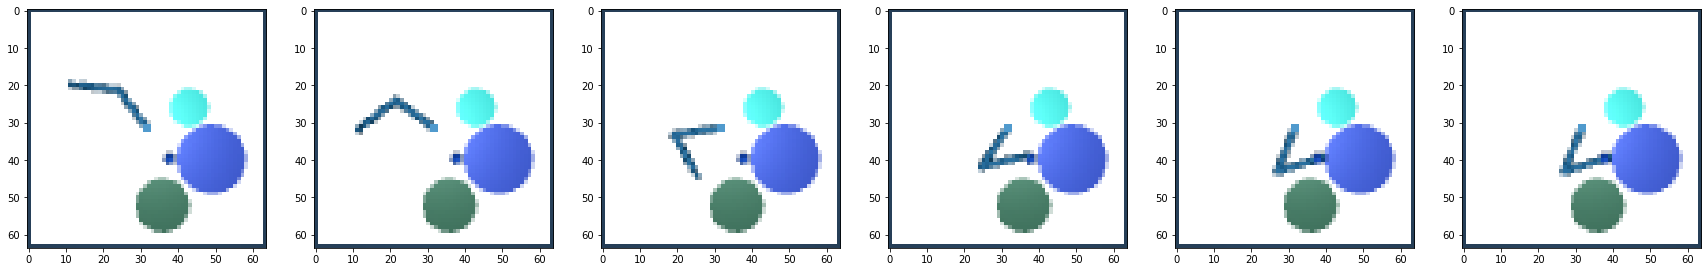

In [7]:
num_frames = 6
_, axes = plt.subplots(nrows=1, ncols=num_frames, figsize=(30, 5))
for i in range(num_frames):
    axes[i].imshow(source_video[i*4])

plt.show()

## Generation of the predicted video

In [8]:
time_step = expert_env.reset()
context_changer.reset()

with utils.change_context(expert_env, context_changer):
    fobs = expert_env.physics.render(im_w, im_h, camera_id=learner_camera_id).copy().transpose((2, 0, 1))
fobs = torch.tensor(fobs, device=utils.device(), dtype=torch.float)
expert_video = torch.tensor(source_video.transpose((0, 3, 1, 2)), device=utils.device(), dtype=torch.float)

state, frame = context_translator.translate(expert_video, fobs)
predicted_video = frame.int().detach().cpu().numpy().transpose((0, 2, 3, 1))

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


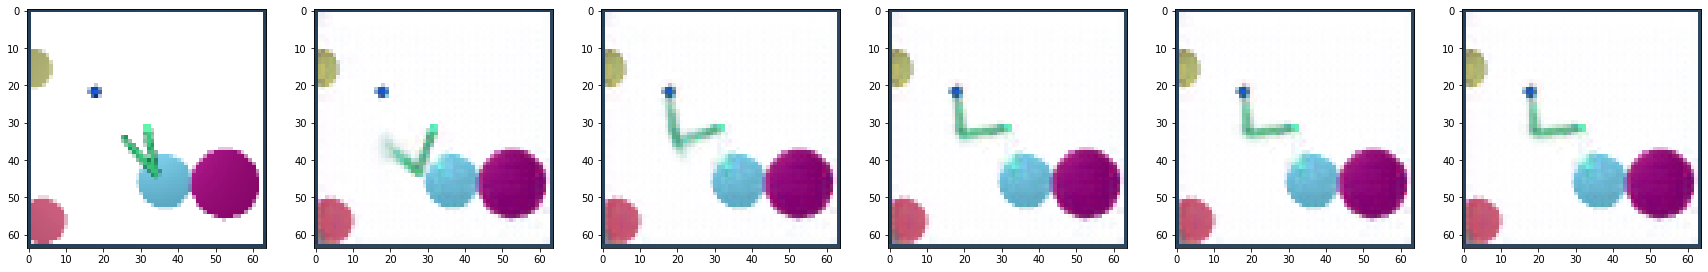

In [9]:
_, axes = plt.subplots(nrows=1, ncols=num_frames, figsize=(30, 5))
for i in range(num_frames):
    axes[i].imshow(predicted_video[i*4])

plt.show()

## Building of the target video

In [10]:
target_video = []
with torch.no_grad():
    with utils.change_context(expert_env, context_changer):
        target_video.append(expert_env.physics.render(im_w, im_h, camera_id=cam_id))
    while not time_step.last():
        action = expert.act(time_step.observation, 1, eval_mode=True)
        time_step = expert_env.step(action)
        with utils.change_context(expert_env, context_changer):
            target_video.append(expert_env.physics.render(im_w, im_h, camera_id=cam_id))

target_video = np.array(target_video)

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


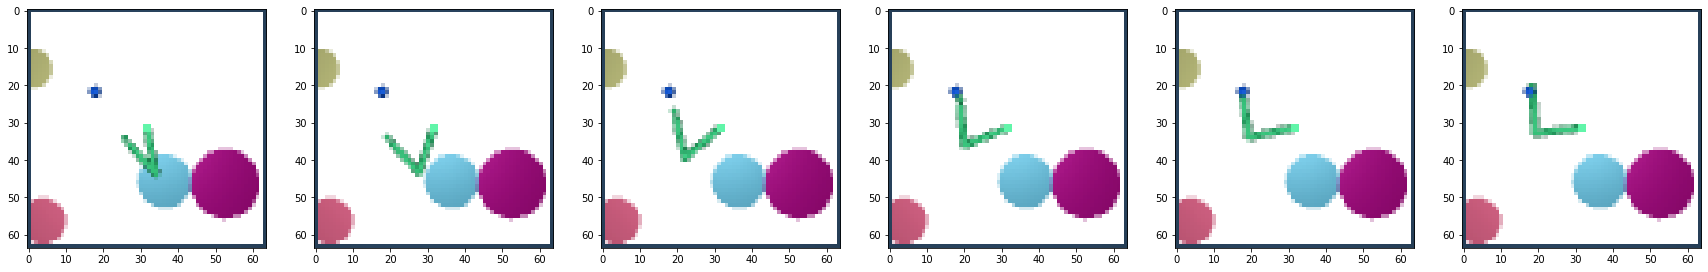

In [11]:
_, axes = plt.subplots(nrows=1, ncols=num_frames, figsize=(30, 5))
for i in range(num_frames):
    axes[i].imshow(target_video[i*4])

plt.show()

In [15]:
all_video = np.zeros( (source_video.shape[0], source_video.shape[1], source_video.shape[2] * 3, source_video.shape[3]))

all_video[:, :, 0:64, :] = source_video
all_video[:, :, 64:128:, :] = predicted_video
all_video[:, :, 128:, :] = target_video

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generation of the final demo video

The video path is `demo/demo_ct.mp4`

In [16]:
imageio.mimwrite('demo/demo_ct.mp4', all_video, format='mp4', fps=24)

/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/medric/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
